# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [3]:
import numpy as np
import pandas as pd

In [18]:
rate_tree = pd.DataFrame({0:[.0174,np.nan],.5:[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [5]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

In [35]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

In [7]:
maturity = 1
face = 100

In [15]:
bond_price_tree.columns[-1:0:-1]

Index(['0.5'], dtype='object', name='time $t$')

In [19]:
bond_price_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

for t in bond_price_tree.columns[-1:0:-1]:
    bond_price_tree[t] = np.exp(-rate_tree[t] * (maturity-t)) * face

bond_price_tree.iloc[0,0] = term_struct.loc[maturity,'price']
bond_price_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)    

time $t$,0.0,0.5
node,,
0,97.8925,98.3193
1,nan,99.5261


### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

In [23]:
dt = 0.5
up = np.exp(rate_tree.iloc[0,0] * dt)
down = np.exp(-rate_tree.iloc[0,0] * dt)

risk_neutral_prob = (up * bond_price_tree.loc[0, 0] - bond_price_tree.loc[1, dt])/ (bond_price_tree.loc[0, dt] - bond_price_tree.loc[1, dt])

risk_neu_df = pd.DataFrame([risk_neutral_prob,1-risk_neutral_prob],index=['up prob','down prob'],columns=[0.5])
risk_neu_df.style.format('{:.2%}').format_index('{:.1f}', axis=1)

,0.5
up prob,64.49%
down prob,35.51%


## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

Swap Tree

In [27]:
def replicating_port(quotes,undertree,derivtree,dt=None,Ncash=100):
    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]
    
    delta = (derivtree.loc[0,dt] - derivtree.loc[1,dt]) / (undertree.loc[0,dt] - undertree.loc[1,dt]) 
    cash = (derivtree.loc[0,dt] - delta * undertree.loc[0,dt]) / Ncash
    
    out = pd.DataFrame({'positions':[cash,delta], 'value':quotes},index=['cash','under'])
    out.loc['derivative','value'] = out['positions'] @ out['value']
    return out

In [25]:
strike = .02
payoff = lambda r: face/2 * (r-strike)
swap_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)
swap_tree[dt] = payoff(rate_tree[dt])

swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5
node,,
0,nan,0.6950
1,nan,-0.5250


In [29]:
replicating_port(term_struct.loc[[.5, 1], 'price'].values, bond_price_tree, swap_tree).style.format('{:.4f}')

,positions,value
cash,1.0009,99.1338
under,-1.0109,97.8925
derivative,nan,0.2595


### 1.4 
What is the price of the swap?

In [30]:
swap_tree.loc[0,0] = down * np.array([risk_neutral_prob, 1-risk_neutral_prob]) @ swap_tree[dt].values
swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

In [45]:
swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

In [31]:
experation = 0.5
strike = .02
payoff = lambda r: face * np.maximum(strike-r,0)

In [32]:
def bintree_pricing(payoff=None, ratetree=None, undertree=None,cftree=None, dt=None, pstars=None, timing=None, cfdelay=False,style='european',Tamerican=0):
    
    if payoff is None:
        payoff = lambda r: 0
    
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]
    
    if timing == 'deferred':
        cfdelay = True
    
    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state,t]
                else:                    
                    cf = cftree.iloc[state,-steps_back]
                
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))
        
    return valuetree

In [38]:
def payoff_bond(r,dt,facevalue=100):
    price = np.exp(-r * dt) * facevalue
    return price

In [37]:
def bond_price_error(quote, pstars, ratetree, style='european'):
    FACEVALUE = 100
    dt = ratetree.columns[1] - ratetree.columns[0]    
    payoff = lambda r: payoff_bond(r,dt)
    modelprice = bintree_pricing(payoff, ratetree, pstars=pstars, style=style).loc[0,0]
    error = modelprice - quote

    return error    

In [33]:
def estimate_pstar(quotes,ratetree,style='european'):

    pstars = pd.Series(dtype=float, index= ratetree.columns[:-1], name='pstar')
    p0 = .5
    
    for steps_forward, t in enumerate(ratetree.columns[1:]):        
        ratetreeT = ratetree.copy().loc[:,:t].dropna(axis=0,how='all')
        t_prev = ratetreeT.columns[steps_forward]
        
        pstars_solved = pstars.loc[:t_prev].iloc[:-1]
        wrapper_fun = lambda p: bond_price_error(quotes['price'].iloc[steps_forward+1], pd.concat([pstars_solved, pd.Series(p,index=[t_prev])]), ratetreeT, style=style)

        pstars[t_prev] = fsolve(wrapper_fun,p0)[0]

    return pstars

In [42]:
def format_bintree(df,style='{:.2f}'):
    return df.style.format(style,na_rep='').format_index('{:.2f}',axis=1)

In [62]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1], ['price']], rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00
pstar,64.49%


### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

In [43]:
option_tree = bintree_pricing(payoff, rate_tree, pstars=pstars)
format_bintree(option_tree, style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.3697,0.0000
1,,1.0500


In [46]:
replicating_port([term_struct.loc[.5,'price'],swap_tree.loc[0,0]], swap_tree, option_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,0.0060,99.1338
under,-0.8607,0.2595
derivative,nan,0.3697


Yes it is the same using the replication

# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

In [47]:
payoff = lambda p: np.maximum(p-strike,0)
strike = 99
experation = .5

In [49]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1], ['price']], rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00
pstar,64.49%


In [50]:
call_tree = bintree_pricing(payoff, rate_tree, undertree=bond_price_tree, pstars=pstars)
format_bintree(call_tree,style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.1852,0.0000
1,,0.5261


In [51]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_price_tree, call_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,-0.4286,99.1338
under,0.4360,97.8925
derivative,nan,0.1852


### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

In [61]:
format_bintree(call_tree,style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.1852,0.0000
1,,0.5261


# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [53]:
new_col = pd.Series([.05,.0256,.0011],name=1)
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series([0,0.5,1],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='').format_index('{:.1f}', axis=1)

time $t$,0.0,0.5,1.0
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

In [54]:
def construct_rate_tree(dt,T):
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree


In [56]:
pstars = estimate_pstar(term_struct, rate_tree_multi)

payoff = lambda r: payoff_bond(r,dt)

bond_tree_multi = bintree_pricing(payoff, rate_tree_multi, pstars=pstars)
format_bintree(bond_tree_multi,style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

In [63]:
pstars = estimate_pstar(term_struct.loc[:, ['price']], rate_tree_multi)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00,0.50
pstar,64.49%,78.69%


### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)


In [66]:
strike = 99
payoff = lambda p: np.maximum(p-strike,0)

derivtree = bintree_pricing(payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars)
format_bintree(derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,0.0706,0.0000,0.0000
1,,0.2004,0.0000
2,,,0.9450


### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

In [69]:
dt = 1/30
TMAT = 1.5

SIM_ADDITIVE = False

if SIM_ADDITIVE:
    sigma = .01
    mu_growth = .0050
    up = mu_growth * dt + sigma * np.sqrt(dt)
    down = mu_growth * dt - sigma * np.sqrt(dt)/2
else:
    sigma = .30
    up = np.exp(sigma*np.sqrt(dt))
    down = np.exp(-sigma*np.sqrt(dt))

ratetree_dense = construct_rate_tree(dt, TMAT-dt)
ratetree_dense.loc[0,0] = rate_tree.loc[0,0]

In [70]:
for tsteps in range(ratetree_dense.shape[1]-1):
    if SIM_ADDITIVE:
        ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] + up
        ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] + down
    else:
        ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] * up        
        ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] * down

format_bintree(ratetree_dense,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%,18.34%,19.37%
1,,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%
2,,,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%
3,,,,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%
4,,,,,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%
5,,,,,,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%
6,,,,,,,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%
7,,,,,,,,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%
8,,,,,,,,,1.12%,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%


In [74]:
pstars = pd.Series(.65, index=ratetree_dense.columns, name='pstar')

format_bintree(pstars.to_frame().T,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
pstar,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%,65.00%


In [90]:
payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(payoff, ratetree_dense, pstars = pstars)
format_bintree(bondtree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,96.1179,96.0323,95.9468,95.8616,95.7769,95.6928,95.6097,95.5278,95.4474,95.3687,95.2921,95.2180,95.1467,95.0787,95.0143,94.9541,94.8986,94.8484,94.8040,94.7660,94.7353,94.7125,94.6984,94.6939,94.7000,94.7176,94.7478,94.7918,94.8508,94.9262,95.0194,95.1320,95.2657,95.4224,95.6039,95.8124,96.0502,96.3198,96.6240,96.9655,97.3477,97.7739,98.2480,98.7739,99.3563
1,,96.4362,96.3593,96.2825,96.2063,96.1306,96.0558,95.9820,95.9096,95.8387,95.7697,95.7030,95.6388,95.5775,95.5195,95.4653,95.4153,95.3700,95.3300,95.2958,95.2681,95.2476,95.2349,95.2309,95.2363,95.2522,95.2794,95.3191,95.3723,95.4403,95.5243,95.6258,95.7462,95.8873,96.0508,96.2385,96.4526,96.6953,96.9689,97.2760,97.6196,98.0026,98.4283,98.9005,99.4229
2,,,96.7305,96.6615,96.5928,96.5247,96.4574,96.3910,96.3258,96.2620,96.1999,96.1398,96.0820,96.0268,95.9746,95.9258,95.8808,95.8400,95.8039,95.7732,95.7482,95.7297,95.7183,95.7147,95.7196,95.7340,95.7585,95.7942,95.8422,95.9034,95.9791,96.0705,96.1790,96.3060,96.4531,96.6221,96.8147,97.0330,97.2790,97.5552,97.8639,98.2079,98.5902,99.0140,99.4826
3,,,,97.0024,96.9406,96.8794,96.8188,96.7591,96.7004,96.6430,96.5872,96.5331,96.4810,96.4314,96.3844,96.3404,96.2999,96.2632,96.2308,96.2031,96.1806,96.1640,96.1537,96.1505,96.1549,96.1678,96.1900,96.2221,96.2653,96.3204,96.3886,96.4708,96.5685,96.6828,96.8152,96.9672,97.1404,97.3367,97.5579,97.8060,98.0834,98.3924,98.7356,99.1158,99.5362
4,,,,,97.2535,97.1984,97.1439,97.0902,97.0375,96.9858,96.9356,96.8869,96.8401,96.7955,96.7532,96.7137,96.6772,96.6442,96.6150,96.5901,96.5699,96.5549,96.5457,96.5428,96.5468,96.5584,96.5783,96.6073,96.6461,96.6957,96.7570,96.8311,96.9189,97.0217,97.1408,97.2775,97.4332,97.6097,97.8084,98.0314,98.2805,98.5580,98.8660,99.2072,99.5842
5,,,,,,97.4853,97.4363,97.3880,97.3406,97.2942,97.2490,97.2052,97.1631,97.1230,97.0850,97.0494,97.0166,96.9869,96.9607,96.9383,96.9201,96.9067,96.8984,96.8957,96.8994,96.9098,96.9277,96.9538,96.9887,97.0334,97.0885,97.1551,97.2341,97.3265,97.4336,97.5565,97.6965,97.8550,98.0336,98.2338,98.4575,98.7066,98.9831,99.2892,99.6273
6,,,,,,,97.6991,97.6557,97.6131,97.5713,97.5307,97.4914,97.4536,97.4175,97.3833,97.3513,97.3219,97.2952,97.2716,97.2514,97.2351,97.2230,97.2156,97.2132,97.2165,97.2259,97.2420,97.2654,97.2969,97.3370,97.3866,97.4464,97.5174,97.6005,97.6968,97.8072,97.9330,98.0754,98.2358,98.4156,98.6165,98.8400,99.0881,99.3627,99.6659
7,,,,,,,,97.8962,97.8579,97.8205,97.7840,97.7486,97.7147,97.6822,97.6515,97.6228,97.5963,97.5723,97.5511,97.5330,97.5183,97.5074,97.5007,97.4986,97.5016,97.5100,97.5245,97.5456,97.5738,97.6099,97.6545,97.7083,97.7721,97.8468,97.9332,98.0324,98.1454,98.2733,98.4174,98.5788,98.7591,98.9598,99.1823,99.4286,99.7005
8,,,,,,,,,98.0780,98.0443,98.0115,97.9798,97.9492,97.9201,97.8925,97.8667,97.8429,97.8214,97.8023,97.7860,97.7729,97.7631,97.7571,97.7552,97.7578,97.7654,97.7784,97.7974,97.8228,97.8552,97.8952,97.9436,98.0009,98.0680,98.1457,98.2347,98.3362,98.4511,98.5804,98.7253,98.8872,99.0672,99.2669,99.4878,99.7315


In [106]:
strike = 99
experation = 1

payoff = lambda r: np.maximum(r-strike,0)

rate_tree_t = ratetree_dense.loc[:, :experation].dropna(axis=0, how='all')
bond_tree_t = bondtree_dense.loc[:, :experation].dropna(axis=0, how='all')

call_tree_dense = bintree_pricing(payoff, rate_tree_t, undertree=bond_tree_t, pstars = pstars)
format_bintree(call_tree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0057,0.0038,0.0025,0.0016,0.0009,0.0005,0.0003,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,,0.0091,0.0063,0.0042,0.0027,0.0017,0.0010,0.0006,0.0003,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,,,0.0143,0.0102,0.0071,0.0047,0.0030,0.0018,0.0010,0.0006,0.0003,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,,,,0.0220,0.0161,0.0114,0.0079,0.0052,0.0033,0.0019,0.0011,0.0006,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,,,,,0.0329,0.0248,0.0181,0.0128,0.0087,0.0057,0.0035,0.0021,0.0011,0.0006,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,,,,,,0.0480,0.0372,0.0280,0.0205,0.0144,0.0097,0.0063,0.0038,0.0022,0.0011,0.0005,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,,,,,,,0.0681,0.0542,0.0421,0.0317,0.0231,0.0162,0.0108,0.0069,0.0041,0.0023,0.0011,0.0005,0.0002,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,,,,,,,,0.0939,0.0768,0.0614,0.0477,0.0360,0.0262,0.0182,0.0121,0.0075,0.0043,0.0023,0.0011,0.0004,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,,,,,,,,,0.1257,0.1055,0.0868,0.0696,0.0543,0.0410,0.0297,0.0205,0.0134,0.0082,0.0046,0.0023,0.0010,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

In [79]:
def exercise_decisions(payoff, undertree, derivtree):
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

In [83]:
STRIKE = 99
payoff = lambda p: np.maximum(STRIKE-p,0)

put_tree_american = bintree_pricing(payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars, style='american')
format_bintree(derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


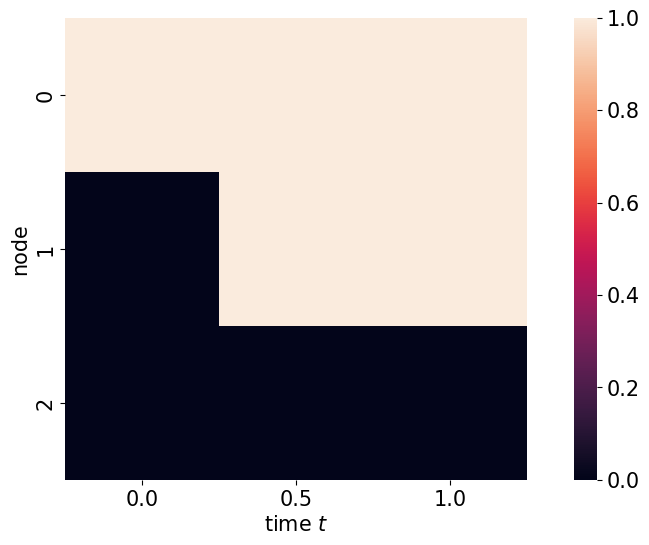

In [84]:
sns.heatmap(exercise_decisions(payoff,bond_tree_multi, put_tree_american), square=True);

### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

In [102]:
pstars = pd.Series(.65, index=ratetree_dense.columns, name='pstar')

In [103]:
strike = 99
experation = 1

payoff = lambda r: np.maximum(strike-r,0)

rate_tree_t = ratetree_dense.loc[:, :experation].dropna(axis=0, how='all')
bond_tree_t = bondtree_dense.loc[:, :experation].dropna(axis=0, how='all')

put_tree_dense = bintree_pricing(payoff, rate_tree_t, undertree=bond_tree_t, pstars = pstars, style='american')
format_bintree(put_tree_dense,style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.8821,2.9677,3.0532,3.1384,3.2231,3.3072,3.3903,3.4722,3.5526,3.6313,3.7079,3.7820,3.8533,3.9213,3.9857,4.0459,4.1014,4.1516,4.1960,4.2340,4.2647,4.2875,4.3016,4.3061,4.3000,4.2824,4.2522,4.2082,4.1492,4.0738,3.9806
1,,2.5638,2.6407,2.7175,2.7937,2.8694,2.9442,3.0180,3.0904,3.1613,3.2303,3.2970,3.3612,3.4225,3.4805,3.5347,3.5847,3.6300,3.6700,3.7042,3.7319,3.7524,3.7651,3.7691,3.7637,3.7478,3.7206,3.6809,3.6277,3.5597,3.4757
2,,,2.2695,2.3385,2.4072,2.4753,2.5426,2.6090,2.6742,2.7380,2.8001,2.8602,2.9180,2.9732,3.0254,3.0742,3.1192,3.1600,3.1961,3.2268,3.2518,3.2703,3.2817,3.2853,3.2804,3.2660,3.2415,3.2058,3.1578,3.0966,3.0209
3,,,,1.9976,2.0594,2.1206,2.1812,2.2409,2.2996,2.3570,2.4128,2.4669,2.5190,2.5686,2.6156,2.6596,2.7001,2.7368,2.7692,2.7969,2.8194,2.8360,2.8463,2.8495,2.8451,2.8322,2.8100,2.7779,2.7347,2.6796,2.6114
4,,,,,1.7465,1.8016,1.8561,1.9098,1.9625,2.0142,2.0644,2.1131,2.1599,2.2045,2.2468,2.2863,2.3228,2.3558,2.3850,2.4099,2.4301,2.4451,2.4543,2.4572,2.4532,2.4416,2.4217,2.3927,2.3539,2.3043,2.2430
5,,,,,,1.5147,1.5637,1.6120,1.6594,1.7058,1.7510,1.7948,1.8369,1.8770,1.9150,1.9506,1.9834,2.0131,2.0393,2.0617,2.0799,2.0933,2.1016,2.1043,2.1006,2.0902,2.0723,2.0462,2.0113,1.9666,1.9115
6,,,,,,,1.3009,1.3443,1.3869,1.4287,1.4693,1.5086,1.5464,1.5825,1.6167,1.6487,1.6781,1.7048,1.7284,1.7486,1.7649,1.7770,1.7844,1.7868,1.7835,1.7741,1.7580,1.7346,1.7031,1.6630,1.6134
7,,,,,,,,1.1038,1.1421,1.1795,1.2160,1.2514,1.2853,1.3178,1.3485,1.3772,1.4037,1.4277,1.4489,1.4670,1.4817,1.4926,1.4993,1.5014,1.4984,1.4900,1.4755,1.4544,1.4262,1.3901,1.3455
8,,,,,,,,,0.9220,0.9557,0.9885,1.0202,1.0508,1.0799,1.1075,1.1333,1.1571,1.1786,1.1977,1.2140,1.2271,1.2369,1.2429,1.2448,1.2422,1.2346,1.2216,1.2026,1.1772,1.1448,1.1048


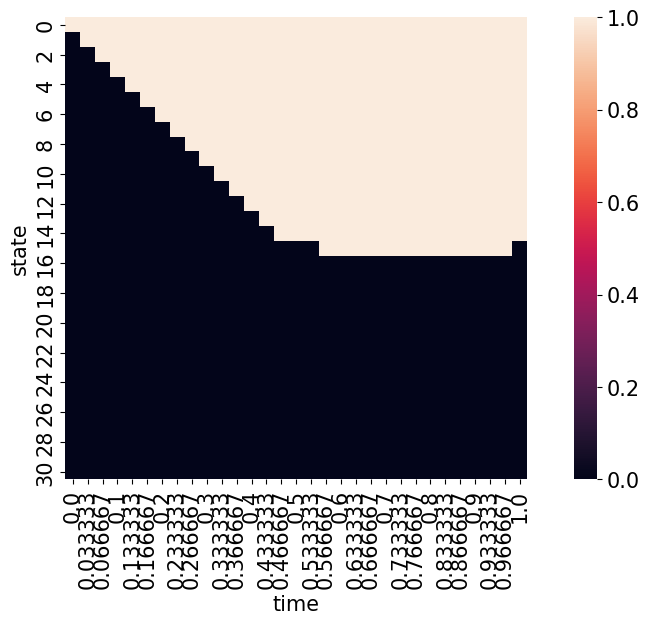

In [104]:
sns.heatmap(exercise_decisions(payoff, bond_tree_t, put_tree_dense), square=True);